In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('PB_All_2000_2021.csv', sep=';')
df

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.50,0.057,154.00,0.454,289.50
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.75,0.034,352.00,0.090,1792.00
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.80,0.173,416.00,0.200,2509.00
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.13,0.099,275.20,0.377,1264.00
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.00,0.065,281.60,0.134,1462.00
...,...,...,...,...,...,...,...,...,...,...,...
2856,22,06.10.2020,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,77.85
2857,22,27.10.2020,0.000,1.52,0.5,11.26,0.56,0.031,147.20,0.634,71.95
2858,22,03.12.2020,0.034,0.29,0.8,11.09,2.58,0.042,209.92,0.484,61.17
2859,22,12.01.2021,0.000,2.10,0.0,14.31,3.94,0.034,121.60,0.424,63.49


In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,year,month,day_of_year,is_spring,is_summer
0,1,2000-02-17,0.330,2.77,12.0,12.30,9.50,0.057,154.00,0.454,289.50,2000,2,48,0,0
1,1,2000-05-11,0.044,3.00,51.6,14.61,17.75,0.034,352.00,0.090,1792.00,2000,5,132,1,0
2,1,2000-09-11,0.032,2.10,24.5,9.87,13.80,0.173,416.00,0.200,2509.00,2000,9,255,0,0
3,1,2000-12-13,0.170,2.23,35.6,12.40,17.13,0.099,275.20,0.377,1264.00,2000,12,348,0,0
4,1,2001-03-02,0.000,3.03,48.8,14.69,10.00,0.065,281.60,0.134,1462.00,2001,3,61,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,22,2020-10-06,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,77.85,2020,10,280,0,0
2857,22,2020-10-27,0.000,1.52,0.5,11.26,0.56,0.031,147.20,0.634,71.95,2020,10,301,0,0
2858,22,2020-12-03,0.034,0.29,0.8,11.09,2.58,0.042,209.92,0.484,61.17,2020,12,338,0,0
2859,22,2021-01-12,0.000,2.10,0.0,14.31,3.94,0.034,121.60,0.424,63.49,2021,1,12,0,0


In [13]:
# Define features and targets
features = ['id', 'year', 'month', 'day_of_year', 'is_spring', 'is_summer']
targets = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']

# Handle missing values
imputer = SimpleImputer(strategy='median')
df[targets] = imputer.fit_transform(df[targets])

# Create lag features (3-month lag)
df = df.sort_values(['id', 'date'])
for target in targets:
    df[f'{target}_lag3'] = df.groupby('id')[target].shift(3)

# Drop initial rows with missing lag values
df = df.dropna(subset=[f'{t}_lag3' for t in targets])

# Prepare final dataset
X = df[features + [f'{t}_lag3' for t in targets]]
y = df[targets]
df

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,...,is_summer,NH4_lag3,BSK5_lag3,Suspended_lag3,O2_lag3,NO3_lag3,NO2_lag3,SO4_lag3,PO4_lag3,CL_lag3
9,1,2002-06-06,0.001,7.11,74.4,19.28,2.26,0.017,409.60,0.181,...,1,0.863,3.91,147.0,10.96,20.500,0.284,595.20,0.674,4023.00
10,1,2002-07-15,0.668,6.81,80.0,10.74,34.00,0.020,505.60,0.222,...,1,0.060,2.97,71.2,13.47,25.800,0.095,314.00,0.390,1907.00
11,1,2002-11-07,0.082,3.00,51.4,13.08,27.05,0.092,314.00,0.179,...,0,0.168,4.15,27.0,17.82,3.945,0.058,153.60,0.110,473.00
12,1,2003-02-24,0.603,3.20,42.0,14.97,9.87,0.169,160.00,0.130,...,0,0.001,7.11,74.4,19.28,2.260,0.017,409.60,0.181,1782.00
13,1,2003-06-13,0.058,2.80,9.3,12.30,15.30,0.060,500.00,0.300,...,1,0.668,6.81,80.0,10.74,34.000,0.020,505.60,0.222,3160.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,22,2020-10-06,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,...,0,0.045,3.88,4.8,11.27,1.210,0.018,121.12,0.398,62.79
2857,22,2020-10-27,0.000,1.52,0.5,11.26,0.56,0.031,147.20,0.634,...,0,0.104,5.10,0.0,11.74,0.400,0.025,128.00,0.493,69.84
2858,22,2020-12-03,0.034,0.29,0.8,11.09,2.58,0.042,209.92,0.484,...,0,0.000,4.70,0.0,11.33,0.000,0.013,160.64,1.214,73.37
2859,22,2021-01-12,0.000,2.10,0.0,14.31,3.94,0.034,121.60,0.424,...,0,0.046,2.69,3.6,8.28,3.800,0.038,160.00,0.726,77.85


In [10]:
# Train-test split (temporal split)
train = df[df['year'] < 2020]
test = df[df['year'] >= 2020]

X_train = train[X.columns]
y_train = train[targets]
X_test = test[X.columns]
y_test = test[targets]

# Create pipeline with scaling and model
pipeline = make_pipeline(
    StandardScaler(),
    MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
    )
)

# Train model
pipeline.fit(X_train, y_train)

# Evaluate model
y_pred = pipeline.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

print(f'Overall RMSE: {rmse:.4f}')
print(f'Overall R²: {r2:.4f}\n')

# Individual parameter performance
print("{:<12} {:<10} {:<10}".format('Parameter', 'RMSE', 'R²'))
for i, target in enumerate(targets):
    rmse_val = np.sqrt(mean_squared_error(y_test[target], y_pred[:, i]))
    r2_val = r2_score(y_test[target], y_pred[:, i])
    print("{:<12} {:<10.4f} {:<10.4f}".format(target, rmse_val, r2_val))
    df

Overall RMSE: 8.7074
Overall R²: 0.1015

Parameter    RMSE       R²        
NH4          0.4494     -0.1355   
BSK5         1.5217     0.4928    
Suspended    5.2358     0.0776    
O2           2.5148     0.3782    
NO3          2.3825     0.1846    
NO2          0.6568     -0.0129   
SO4          23.8155    0.6895    
PO4          0.3144     -1.3184   
CL           8.5281     0.5577    


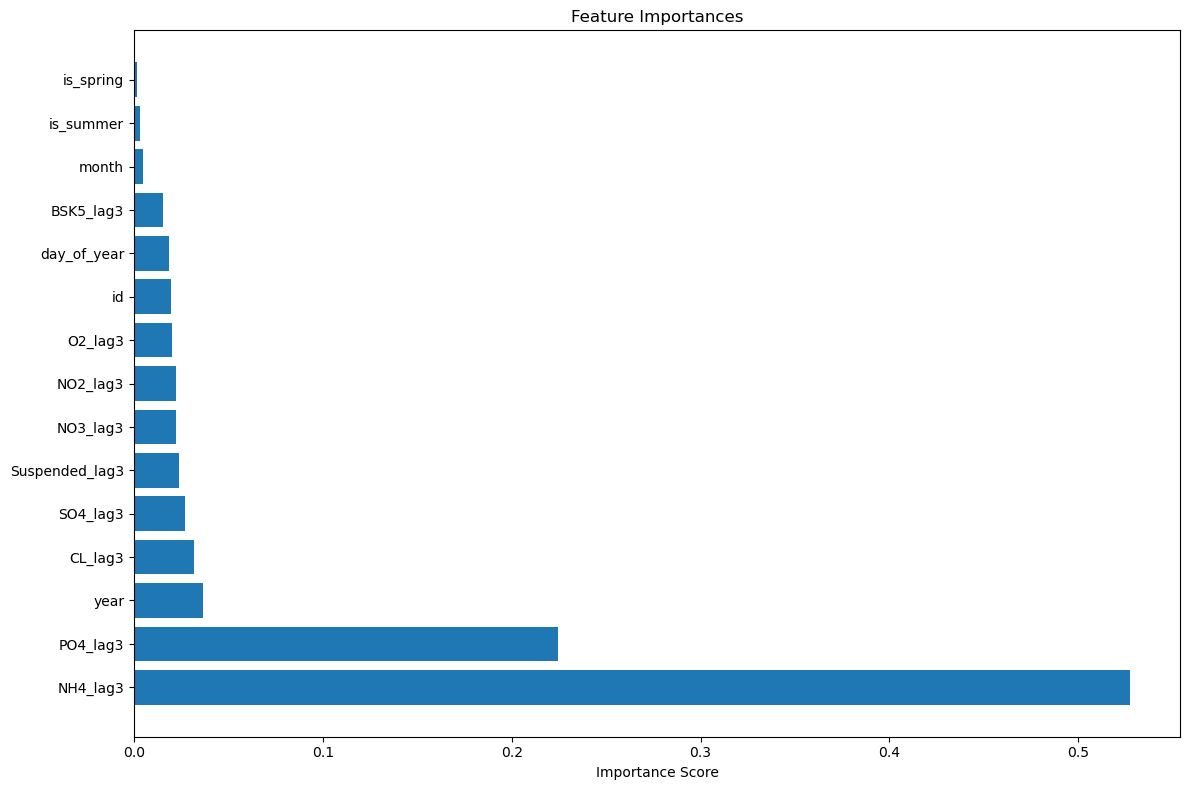

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,...,is_summer,NH4_lag3,BSK5_lag3,Suspended_lag3,O2_lag3,NO3_lag3,NO2_lag3,SO4_lag3,PO4_lag3,CL_lag3
6,1,2001-09-10,0.863,3.91,147.0,10.96,20.500,0.284,595.20,0.674,...,0,0.170,2.23,35.6,12.40,17.13,0.099,275.20,0.377,1264.00
7,1,2001-11-06,0.060,2.97,71.2,13.47,25.800,0.095,314.00,0.390,...,0,0.000,3.03,48.8,14.69,10.00,0.065,281.60,0.134,1462.00
8,1,2002-03-12,0.168,4.15,27.0,17.82,3.945,0.058,153.60,0.110,...,0,0.020,4.02,34.0,10.61,11.80,0.016,287.00,0.208,1183.00
9,1,2002-06-06,0.001,7.11,74.4,19.28,2.260,0.017,409.60,0.181,...,1,0.863,3.91,147.0,10.96,20.50,0.284,595.20,0.674,4023.00
10,1,2002-07-15,0.668,6.81,80.0,10.74,34.000,0.020,505.60,0.222,...,1,0.060,2.97,71.2,13.47,25.80,0.095,314.00,0.390,1907.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,22,2020-10-06,0.046,2.69,3.6,8.28,3.800,0.038,160.00,0.726,...,0,0.045,3.88,4.8,11.27,1.21,0.018,121.12,0.398,62.79
2857,22,2020-10-27,0.000,1.52,0.5,11.26,0.560,0.031,147.20,0.634,...,0,0.104,5.10,0.0,11.74,0.40,0.025,128.00,0.493,69.84
2858,22,2020-12-03,0.034,0.29,0.8,11.09,2.580,0.042,209.92,0.484,...,0,0.000,4.70,0.0,11.33,0.00,0.013,160.64,1.214,73.37
2859,22,2021-01-12,0.000,2.10,0.0,14.31,3.940,0.034,121.60,0.424,...,0,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,77.85


In [11]:
import matplotlib.pyplot as plt

# Get feature importances
rf_model = pipeline.named_steps['multioutputregressor'].estimators_[0]
importances = rf_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 8))
sorted_idx = importances.argsort()[::-1]
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()
df

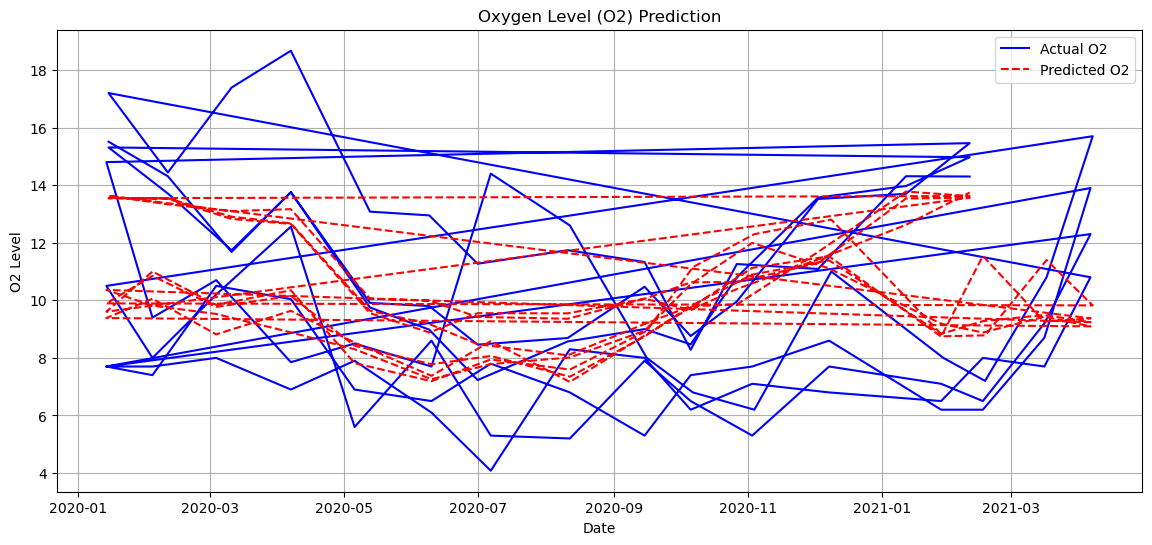

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,...,is_summer,NH4_lag3,BSK5_lag3,Suspended_lag3,O2_lag3,NO3_lag3,NO2_lag3,SO4_lag3,PO4_lag3,CL_lag3
6,1,2001-09-10,0.863,3.91,147.0,10.96,20.500,0.284,595.20,0.674,...,0,0.170,2.23,35.6,12.40,17.13,0.099,275.20,0.377,1264.00
7,1,2001-11-06,0.060,2.97,71.2,13.47,25.800,0.095,314.00,0.390,...,0,0.000,3.03,48.8,14.69,10.00,0.065,281.60,0.134,1462.00
8,1,2002-03-12,0.168,4.15,27.0,17.82,3.945,0.058,153.60,0.110,...,0,0.020,4.02,34.0,10.61,11.80,0.016,287.00,0.208,1183.00
9,1,2002-06-06,0.001,7.11,74.4,19.28,2.260,0.017,409.60,0.181,...,1,0.863,3.91,147.0,10.96,20.50,0.284,595.20,0.674,4023.00
10,1,2002-07-15,0.668,6.81,80.0,10.74,34.000,0.020,505.60,0.222,...,1,0.060,2.97,71.2,13.47,25.80,0.095,314.00,0.390,1907.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,22,2020-10-06,0.046,2.69,3.6,8.28,3.800,0.038,160.00,0.726,...,0,0.045,3.88,4.8,11.27,1.21,0.018,121.12,0.398,62.79
2857,22,2020-10-27,0.000,1.52,0.5,11.26,0.560,0.031,147.20,0.634,...,0,0.104,5.10,0.0,11.74,0.40,0.025,128.00,0.493,69.84
2858,22,2020-12-03,0.034,0.29,0.8,11.09,2.580,0.042,209.92,0.484,...,0,0.000,4.70,0.0,11.33,0.00,0.013,160.64,1.214,73.37
2859,22,2021-01-12,0.000,2.10,0.0,14.31,3.940,0.034,121.60,0.424,...,0,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,77.85


In [12]:
# Visualize actual vs predicted for O2
plt.figure(figsize=(14, 6))
plt.plot(test['date'], y_test['O2'], 'b-', label='Actual O2')
plt.plot(test['date'], y_pred[:, targets.index('O2')], 'r--', label='Predicted O2')
plt.title('Oxygen Level (O2) Prediction')
plt.xlabel('Date')
plt.ylabel('O2 Level')
plt.legend()
plt.grid(True)
plt.show()
df